In [34]:
import numpy as np  
import matplotlib.pyplot as plt  
from sklearn.cluster import KMeans
import pandas as pd
from scipy.spatial.distance import cdist
from PIL import Image

from lib.file.TIF import *
from lib.file.ROI_reader import ROIFileReader
from lib.analysis.laminar_dist import LaminarROI
from lib.utilities import *
from lib.analysis.ROI_identification import *
from lib.file.ROI_writer import ROIFileWriter
from lib.file.TSV import RegionExporter

# implementation of single-cell identification as outlined in 
# https://www.proquest.com/docview/2838882181?pq-origsite=gscholar&fromopenview=true&sourcetype=Dissertations%20&%20Theses
# and implemented in R/Python here: https://github.com/ksscheuer/ROI_Identification
# https://github.com/ksscheuer/Single_Cell_Identification/blob/main/AutomaticallyChooseROIs_part1.R


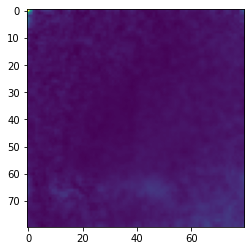

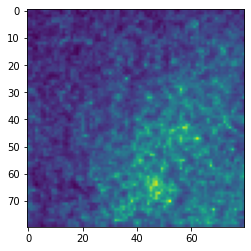

In [35]:
data_dir = "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/pv-cre-mCherry/02-20-24/"
dic_dir = data_dir + 'dic/'
data_dir = data_dir + "zda/"
target_recording = '02_01_04'
tdTomato_rois = data_dir + 'ROIs-red' + target_recording + '.dat'
bkg_mCherry_intensity_map = '2-1r.tif'
bkg_CeFP_intensity_map = '2-1f.tif'
# input files: *_amp.dat, *_snr.dat   # do not normalize!
cluster_SNRcutoff = 1

ROI_px_cutoff = 9
SNR_cutoff = 2.5
Amp_cutoff = 1

data = {}
for fn in ['_amp.dat', '_snr.dat']:
    fn2 = data_dir + target_recording + fn
    data_arr = pd.read_csv(fn2,
                                 sep='\t',
                                 header=None,
                                 names=['Index',  'Values'])
    data_arr = np.array(data_arr['Values']).reshape((80, 80))
    plt.imshow(data_arr)
    plt.show()
    data[fn] = data_arr

n, m = data['_amp.dat'].shape

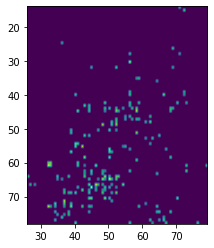

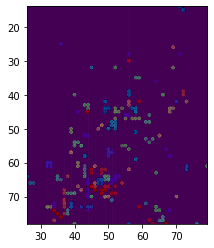

Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/pv-cre-mCherry/02-20-24/zda/ROIs-GMM-02_01_04_96-99.dat


In [36]:
# single_images structure:
# single_images[slic][loc][image_type] = dic_image 2-D array
#    where image_type is ['e', 'f', 'i'] for electrode, fluorescent, or image
# single_images[slic][loc][map_type][rec] = dat_image 2-D array
#    where map_type is ['Amp', 'SNR', 'Nos'] for amplitude, SNR< or no-stim SNR
# single_images[slic][loc]['stims'] = [stim list indexed by rec #]
roi = GMM_ROI_Identifier()
reg_exp = RegionExporter()

percentile_strata = [[96, 99]]
k_cluster = 90
sampling_size = 10000

snr = data['_snr.dat']
w, h = snr.shape
cluster_strata = []

for stratum in percentile_strata:
    low_cutoff, hi_cutoff = stratum

    sampled_points = roi.generate_points(snr, n_points=sampling_size, 
                                            percentile_cutoff=low_cutoff,
                                            upper_cutoff=hi_cutoff)

    roi.heatmap_of_scatter(sampled_points, w, h) # should look similar
    k = k_cluster

    if k is None:
        # use AIC and elbow method, then enter choice of k above
        roi.find_gmm_cluster_number(sampled_points, k_start=30, k_step=10, k_search=91)
        break
    else: # after manually selecting k
        labels = roi.gaussian_mixture_model(sampled_points, k, show=False)

        roi.draw_gmm_enclosures(sampled_points, labels, a=0.01, s=10)

        # print ROIs to a DAT file to be loaded into PhotoZ
        filename = data_dir + "ROIs-GMM-" + target_recording + "_" + str(low_cutoff) + "-" + str(hi_cutoff) + ".dat"
        roi_write = ROIFileWriter()
        regions = roi_write.export_clusters(filename, labels, sampled_points, w)
        all_regions_by_pixel = roi_write.get_regions_by_pixel()
        # regions is in format of doubly-nested list of PhotoZ diode numbers

        cluster_objs = []
        for px_region in all_regions_by_pixel:
            cluster_objs.append(Cluster(px_region, w))
            
        cluster_strata.append(cluster_objs)
        data['gmm-rois-filename'] = filename

number of ROIs: 1
[[[75, 14], [59, 8], [53, 11], [44, 16], [51, 19], [55, 24], [56, 23], [68, 24], [73, 30], [68, 27], [67, 30], [68, 33], [63, 34], [65, 35], [66, 38], [64, 38], [62, 36], [61, 38], [58, 36], [59, 39], [58, 41], [55, 38], [54, 37], [53, 32], [52, 41], [50, 42], [49, 42], [46, 42], [44, 43], [42, 44], [37, 42], [36, 41], [36, 37], [29, 36], [34, 32], [20, 40], [13, 45], [20, 47], [21, 48], [32, 48], [37, 47], [41, 48], [45, 50], [47, 50], [50, 49], [49, 47], [53, 47], [53, 46], [61, 45], [63, 44], [66, 45], [68, 44], [71, 44], [74, 47], [63, 42], [63, 40], [57, 44], [68, 40], [71, 38], [71, 41], [37, 28], [25, 47], [26, 44], [26, 53], [29, 54], [29, 60], [15, 65], [15, 68], [21, 77], [20, 78], [29, 73], [24, 68], [28, 69], [30, 70], [33, 69], [36, 69], [35, 57], [33, 55], [29, 40], [41, 52], [40, 55], [39, 54], [42, 55], [42, 60], [39, 61], [34, 65], [34, 76], [72, 74], [74, 77], [68, 71], [67, 69], [65, 70], [63, 69], [61, 71], [63, 74], [61, 75], [63, 77], [66, 78], [

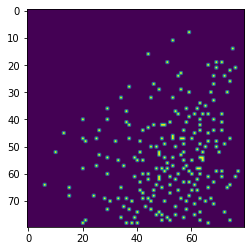

213.0
number of ROIs: 90
[[[34, 72], [34, 73]], [[55, 46], [56, 46]], [[51, 65], [52, 65], [51, 66], [53, 64], [52, 64]], [[68, 74]], [[64, 36]], [[44, 52], [43, 52]], [[67, 56], [68, 58]], [[44, 68], [44, 70], [44, 66], [44, 65], [44, 74], [44, 69]], [[56, 28]], [[41, 45]], [[71, 28]], [[36, 25]], [[33, 61], [32, 61], [33, 60], [32, 60]], [[50, 58], [50, 57], [51, 57], [50, 56]], [[70, 42]], [[42, 73], [44, 73], [45, 73]], [[56, 78]], [[73, 62], [73, 61]], [[47, 65], [48, 66], [48, 65], [47, 66]], [[39, 73], [39, 72]], [[71, 14], [72, 15]], [[49, 45], [50, 44], [49, 42], [49, 44]], [[58, 51]], [[56, 39], [56, 40]], [[43, 58]], [[58, 44], [58, 45], [57, 44]], [[58, 59]], [[52, 48], [51, 49], [52, 49], [52, 50], [50, 50], [51, 48]], [[28, 66], [26, 64], [27, 66]], [[45, 32]], [[61, 72]], [[76, 78]], [[51, 71]], [[35, 65], [35, 64], [36, 65]], [[38, 74], [38, 75]], [[66, 77], [65, 77], [66, 76]], [[43, 61], [43, 63], [43, 62], [43, 64]], [[62, 46], [62, 48], [61, 48]], [[61, 53], [63, 53

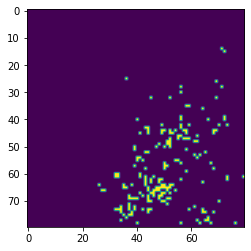

192.0


In [37]:
# read in red labels and hVOS labels
roi_maps = []
hvos_rois = data['gmm-rois-filename']
for rois_filename in [tdTomato_rois, hvos_rois]:
    rfr = ROIFileReader(rois_filename)
    rois = rfr.get_roi_list()

    print("number of ROIs:", len(rois))
    rois = [LaminarROI(rr).get_points() for rr in rois]
    print(rois, len(rois))
    roi_map = np.zeros((n, m))
    for roi in rois:
        for px in roi:
            i, j = px
            roi_map[j][i] = 1
    plt.imshow(roi_map)
    plt.show()
    print(np.sum(roi_map))
    roi_maps.append(roi_map)



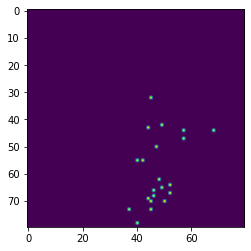

21


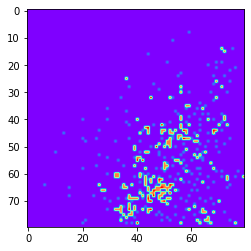

In [38]:
# overlap of red_roi_map and kkm_roi_map
red_roi_map, gmm_roi_map = roi_maps
overlap_map = np.logical_and(red_roi_map, gmm_roi_map)
plt.imshow(overlap_map)
plt.show()
print(np.sum(overlap_map))

superpose_map = red_roi_map + gmm_roi_map*5
plt.imshow(superpose_map, cmap='rainbow')

(5013504, 3)
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/pv-cre-mCherry/02-20-24/dic/2-1r.tif


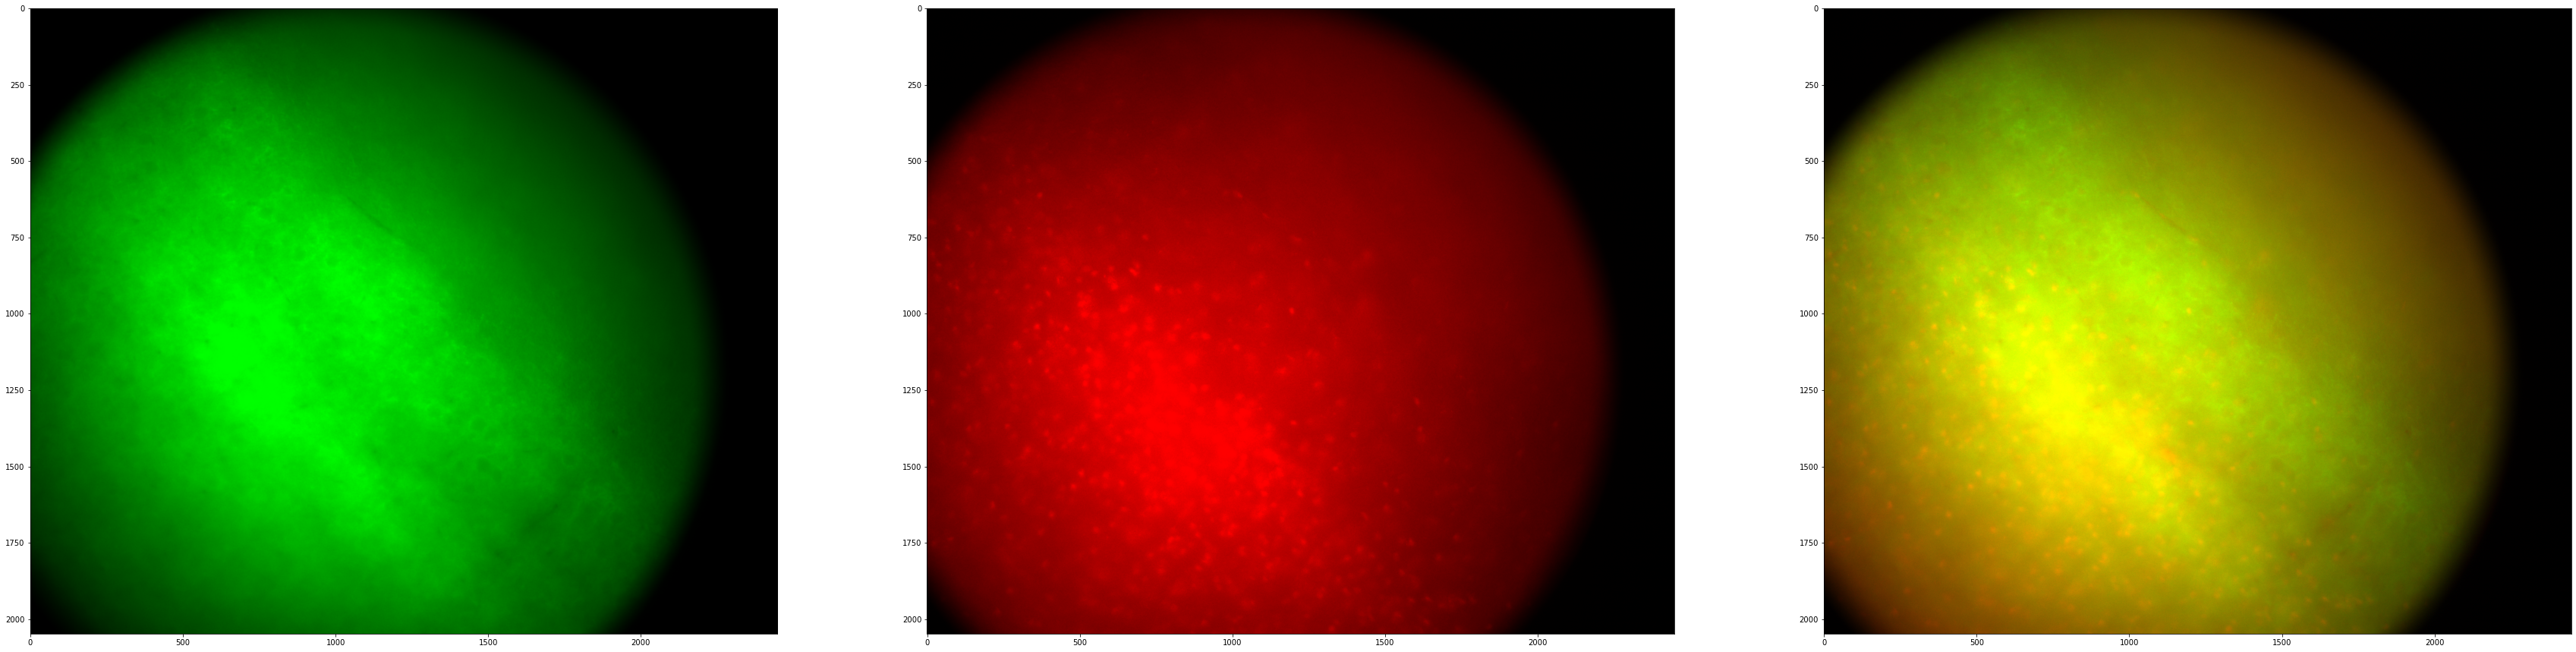

In [39]:
channel_mCherry = 0
channel_hVOS = 2
channel_CeFP = 1

# plot the hVOS snr as a green image
'''hvos_snr_map = np.zeros((n, m, 3))
min_intensity = np.min(data['_snr.dat'])
max_intensity = np.max(data['_snr.dat'])
print(min_intensity, max_intensity)
hvos_snr_map[:, :, channel_hVOS] = 255 * (data['_snr.dat'] - min_intensity) / (max_intensity - min_intensity)
hvos_snr_map = hvos_snr_map.astype(np.uint8)'''

# plot the bkg CeFP intensity as a blue image
CeFP_intensity_map = dic_dir + bkg_CeFP_intensity_map
CeFP_intensity = np.array(Image.open(CeFP_intensity_map).getdata())
print(CeFP_intensity.shape)
n, m = 2048, 2448

CeFP_intensity = CeFP_intensity.reshape((n, m, 3))
tmp_avg = np.average(CeFP_intensity, axis=2)
CeFP_intensity[:, :, :] =   0
CeFP_intensity[:, :, channel_CeFP] = tmp_avg
min_intensity = np.min(CeFP_intensity[:, :, channel_CeFP])
max_intensity = np.max(CeFP_intensity[:, :, channel_CeFP])
# normalize CeFP_intensity 0 - 255
CeFP_intensity[:, :, channel_CeFP] = (CeFP_intensity[:, :, channel_CeFP] - min_intensity)
CeFP_intensity = CeFP_intensity[:, :,:3]


# plot the mCherry intensity as a red image
mCherry_intensity_map = dic_dir + bkg_mCherry_intensity_map
print(mCherry_intensity_map)
mCherry_intensity = np.array(Image.open(mCherry_intensity_map).getdata()).reshape((n, m, 3))
tmp_avg = np.average(mCherry_intensity, axis=2)
mCherry_intensity[:, :, :] =   0
mCherry_intensity[:, :, channel_mCherry] = tmp_avg
min_intensity = np.min(mCherry_intensity[:, :, channel_mCherry])
max_intensity = np.max(mCherry_intensity[:, :, channel_mCherry])
# normalize mCherry_intensity 0 - 255
mCherry_intensity[:, :, channel_mCherry] = (mCherry_intensity[:, :, channel_mCherry] - min_intensity)
mCherry_intensity = mCherry_intensity[:, :,:3]



# merge the images
merged = mCherry_intensity + CeFP_intensity # + hvos_snr_map 


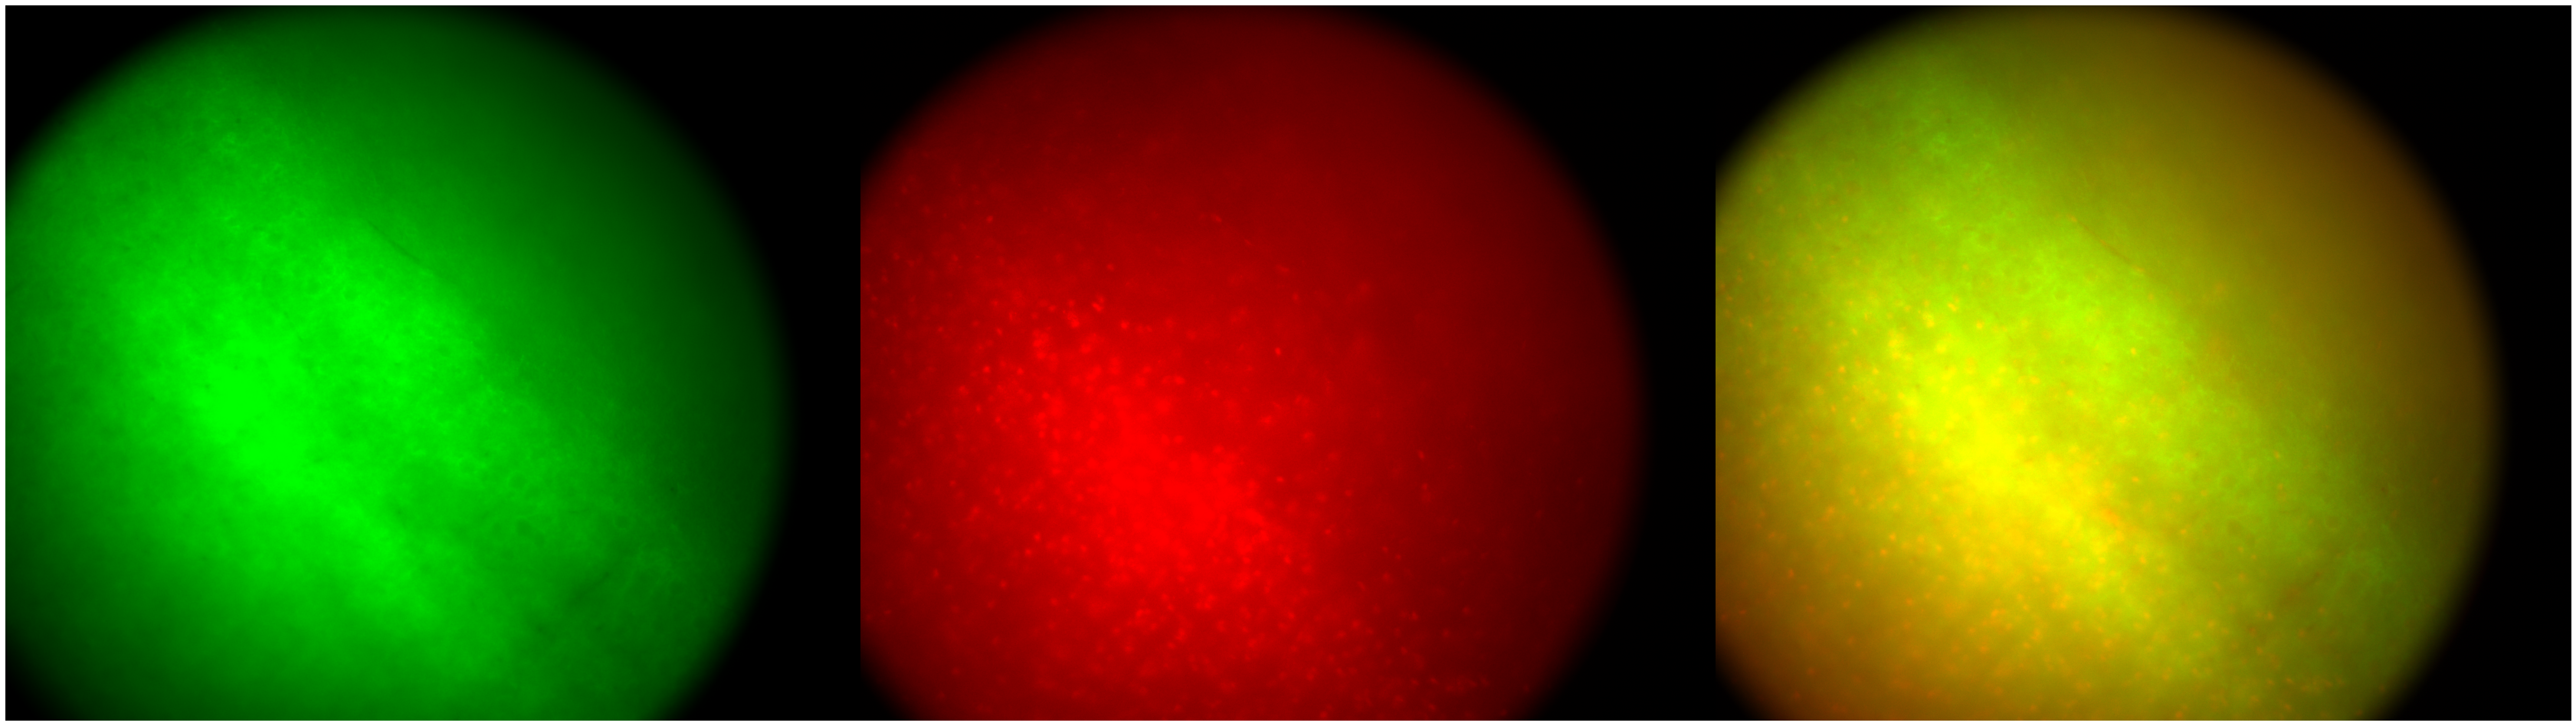

In [41]:
# plot the 3 images side by side using subplots
fig, ax = plt.subplots(1, 3, figsize=(60, 20))
ax[0].imshow(CeFP_intensity)
ax[1].imshow(mCherry_intensity)
ax[2].imshow(merged)
for a in ax:
    a.axis('off')
# remove space between the subplots
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()